In [1]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.base import clone 
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [3]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Ignore warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv('mobile_price_range_data.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [5]:
df.info() # find out null values if any

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [6]:
# Filter out categorical features
df_categorical = df[['price_range', 'n_cores', 'blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']].astype(str)

unique_counts = df_categorical.nunique()
unique_values = df_categorical.apply(lambda x: x.unique())

pd.DataFrame({'Number of Unique Values': unique_counts, 'Unique Values': unique_values})

,Number of Unique Values,Unique Values
price_range,4,"[1, 2, 3, 0]"
n_cores,8,"[2, 3, 5, 6, 1, 8, 4, 7]"
blue,2,"[0, 1]"
dual_sim,2,"[0, 1]"
four_g,2,"[0, 1]"
three_g,2,"[0, 1]"
touch_screen,2,"[0, 1]"
wifi,2,"[1, 0]"


In [7]:
# Filter out numerical features
df_numerical = df.drop(df_categorical.columns, axis=1)

# descriptive statistics
df_numerical.describe().T.round(1)


,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.5,439.4,501.0,851.8,1226.0,1615.2,1998.0
clock_speed,2000.0,1.5,0.8,0.5,0.7,1.5,2.2,3.0
fc,2000.0,4.3,4.3,0.0,1.0,3.0,7.0,19.0
int_memory,2000.0,32.0,18.1,2.0,16.0,32.0,48.0,64.0
m_dep,2000.0,0.5,0.3,0.1,0.2,0.5,0.8,1.0
mobile_wt,2000.0,140.2,35.4,80.0,109.0,141.0,170.0,200.0
pc,2000.0,9.9,6.1,0.0,5.0,10.0,15.0,20.0
px_height,2000.0,645.1,443.8,0.0,282.8,564.0,947.2,1960.0
px_width,2000.0,1251.5,432.2,500.0,874.8,1247.0,1633.0,1998.0
ram,2000.0,2124.2,1084.7,256.0,1207.5,2146.5,3064.5,3998.0


In [12]:
# Create the subplots
fig = make_subplots(rows=3, cols=3, specs=[[{'type':'domain'}]*3]*3, vertical_spacing=0.05, horizontal_spacing=0.01)

for i, feature in enumerate(df_categorical.columns):
    value_counts = df_categorical[feature].value_counts()
    labels = value_counts.index.tolist()
    values = value_counts.values.tolist()

    cmap = colors.LinearSegmentedColormap.from_list("blue", ["blue", "white"])
    norm = colors.Normalize(vmin=0, vmax=len(labels))
    color_list = [colors.rgb2hex(cmap(norm(i))) for i in range(len(labels))]

    pie_chart = go.Pie(
        labels=labels,
        values=values,
        hole=0.6,
        marker=dict(colors=color_list, line=dict(color='white', width=3)),
        textposition='inside',
        textinfo='percent+label',
        title=feature,  # Add title with the feature name
        title_font=dict(size=25, color='black', family='Calibri')
    )

    if i < 8:
        row = i // 3 + 1
        col = i % 3 + 1
        fig.add_trace(pie_chart, row=row, col=col)

# Update the layout
fig.update_layout(showlegend=False, height=1000, width=980, 
                   title={
                          'text':"Distribution of Categorical Variables",
                          'y':0.95,
                          'x':0.5,
                          'xanchor':'center',
                          'yanchor':'top',
                          'font': {'size':28, 'color':'black', 'family':'Calibri'}
                         })

# Show the plot
fig.show()


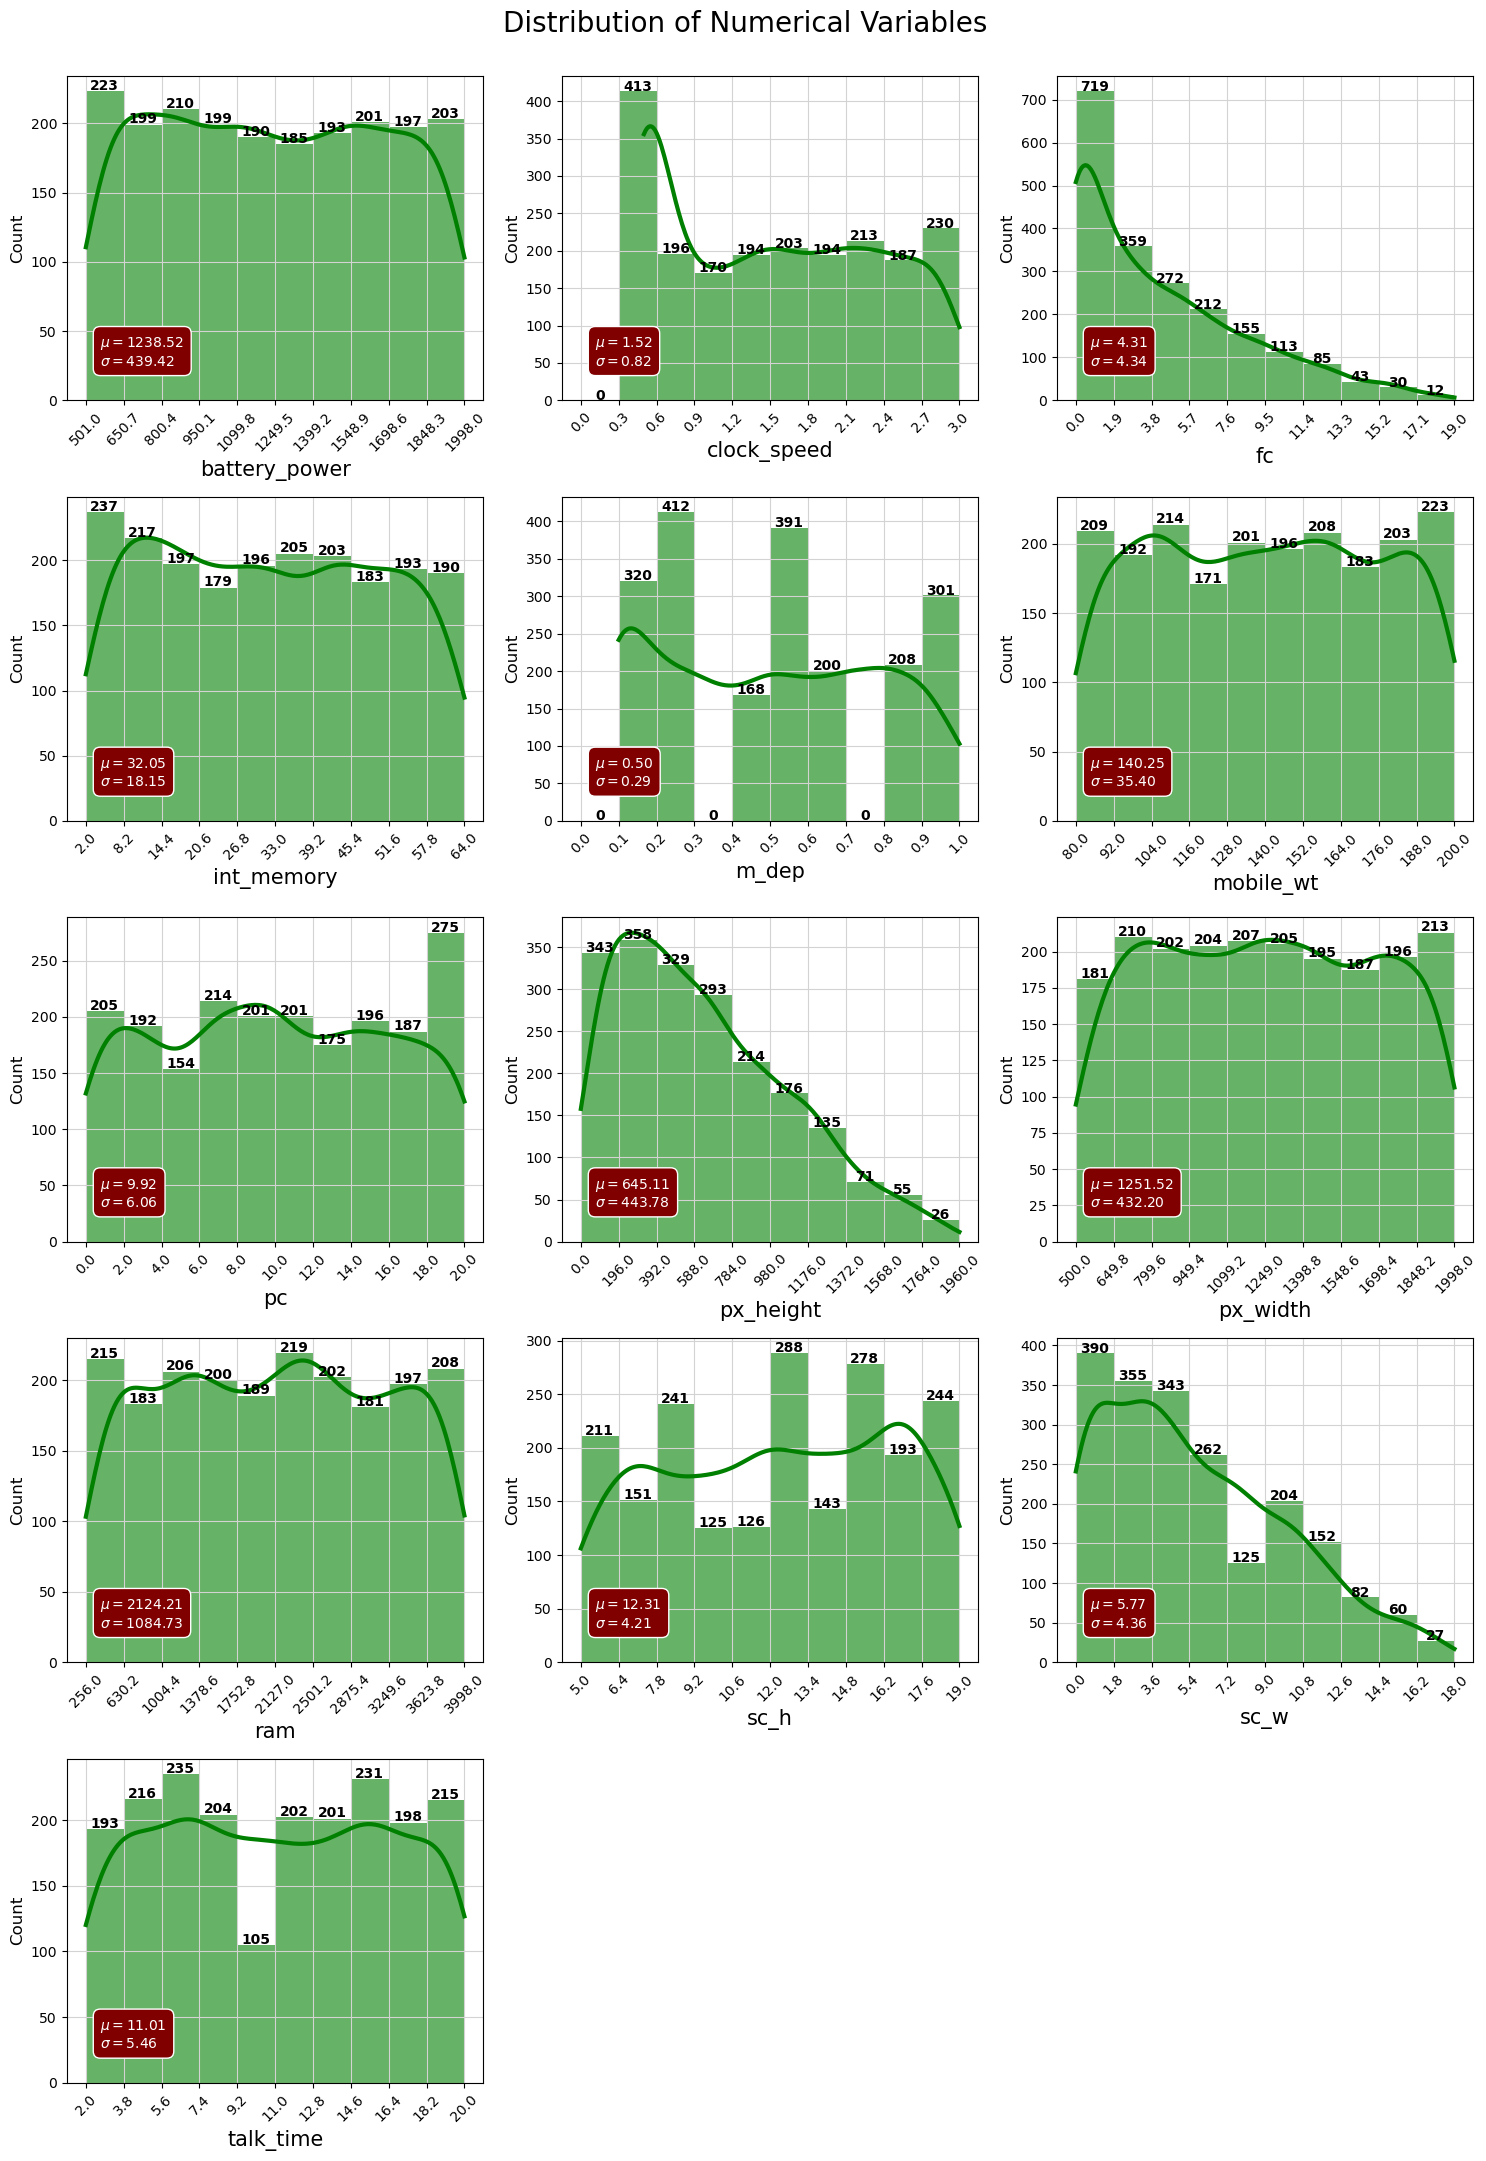

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15,22)) #, dpi=200
c = 'green'

for i, col in enumerate(df_numerical.columns):
    x = i//3
    y = i%3
    values, bin_edges = np.histogram(df_numerical[col], 
                                     range=(np.floor(df_numerical[col].min()), np.ceil(df_numerical[col].max())))                
    graph = sns.histplot(data=df_numerical, x=col, bins=bin_edges, kde=True, ax=ax[x,y],
                         edgecolor='none', color=c, alpha=0.6, line_kws={'lw': 3})
    ax[x,y].set_xlabel(col, fontsize=15)
    ax[x,y].set_ylabel('Count', fontsize=12)
    ax[x,y].set_xticks(np.round(bin_edges,1))
    ax[x,y].set_xticklabels(ax[x,y].get_xticks(), rotation = 45)
    ax[x,y].grid(color='lightgrey')
    for j,p in enumerate(graph.patches):
        ax[x,y].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")
    textstr = '\n'.join((
    r'$\mu=%.2f$' %df_numerical[col].mean(),
    r'$\sigma=%.2f$' %df_numerical[col].std()
    ))
    ax[x,y].text(0.08, 0.2, textstr, transform=ax[x,y].transAxes, fontsize=10, verticalalignment='top',
                color='white', bbox=dict(boxstyle='round',facecolor='maroon', edgecolor='white', pad=0.5))
    
ax[4, 1].axis('off')
ax[4, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20) 
plt.tight_layout()   
plt.subplots_adjust(top=0.95)
plt.show()


In [14]:
df.duplicated().sum()


0

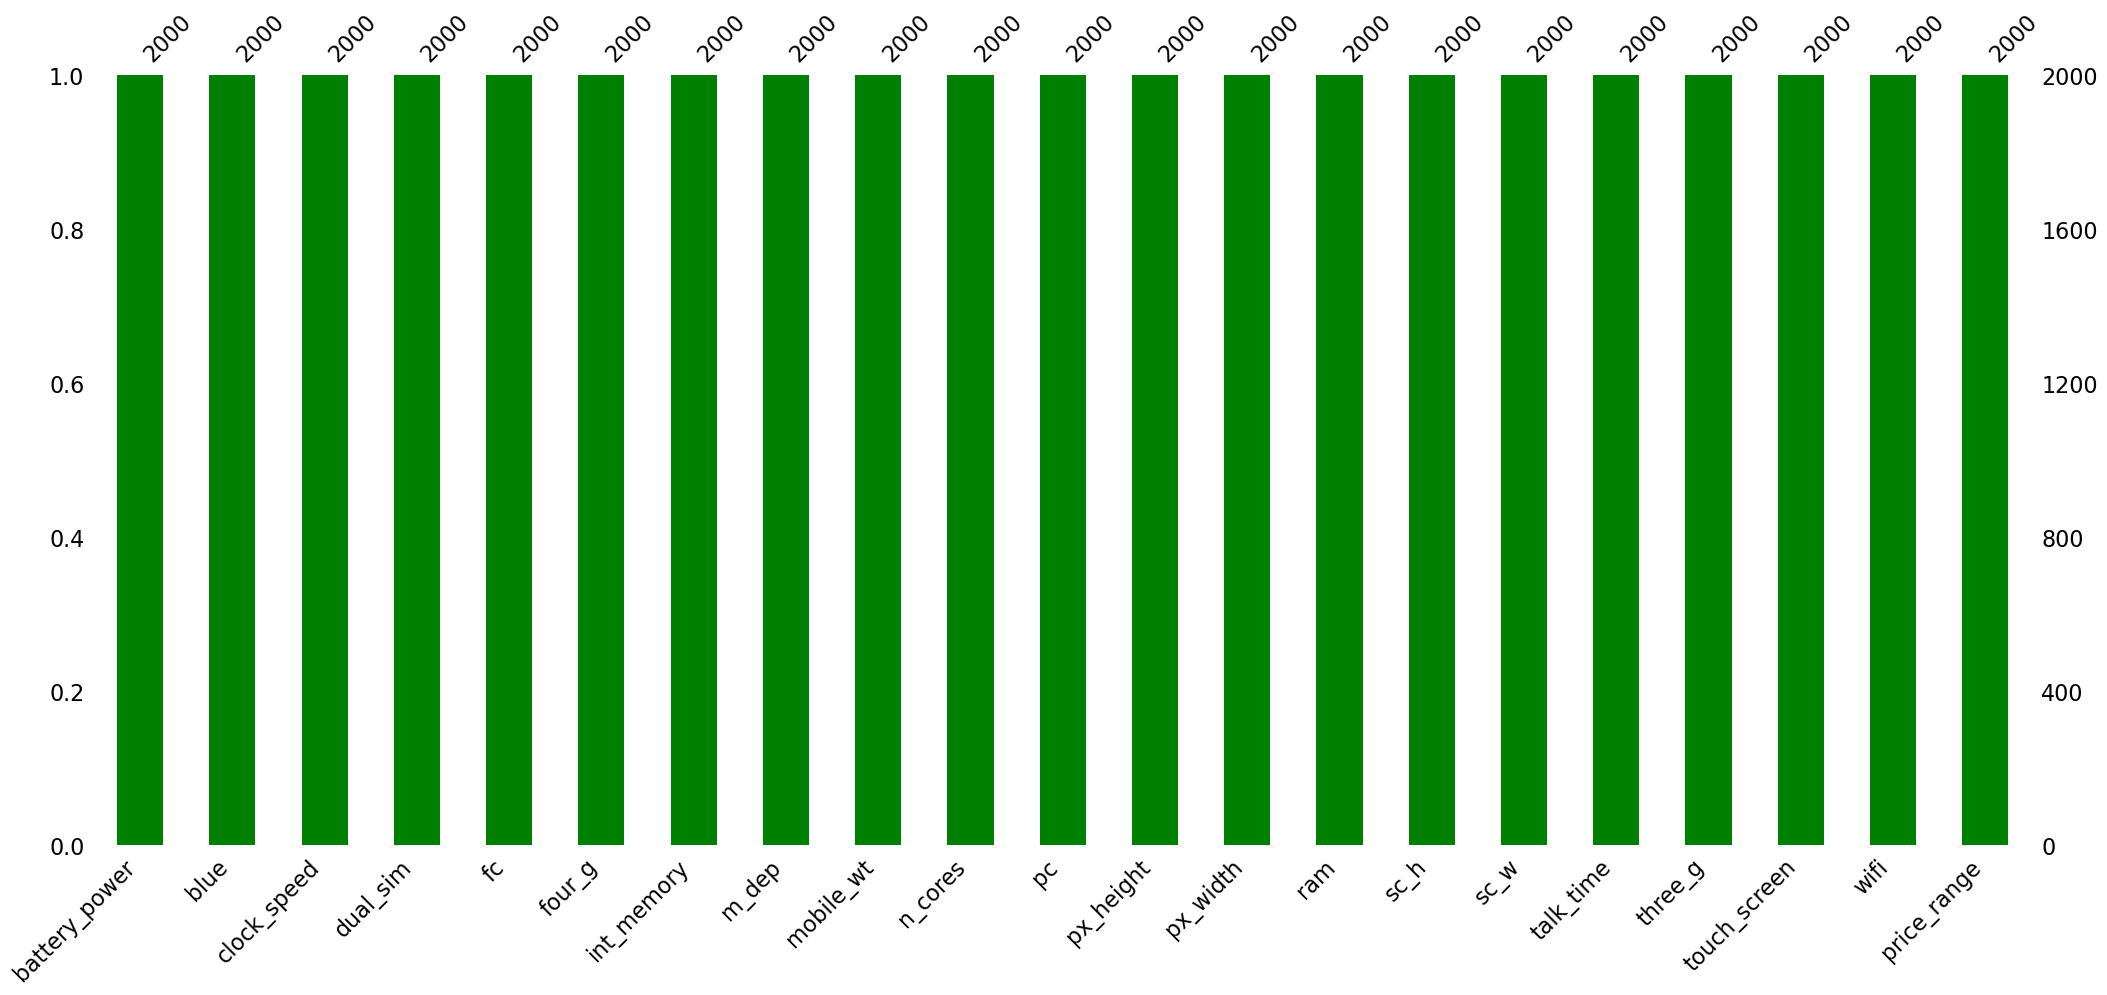

In [15]:
# Generate the missing values matrix using missingno.bar()
msno.bar(df, color='green')

# Display the plot
plt.show()

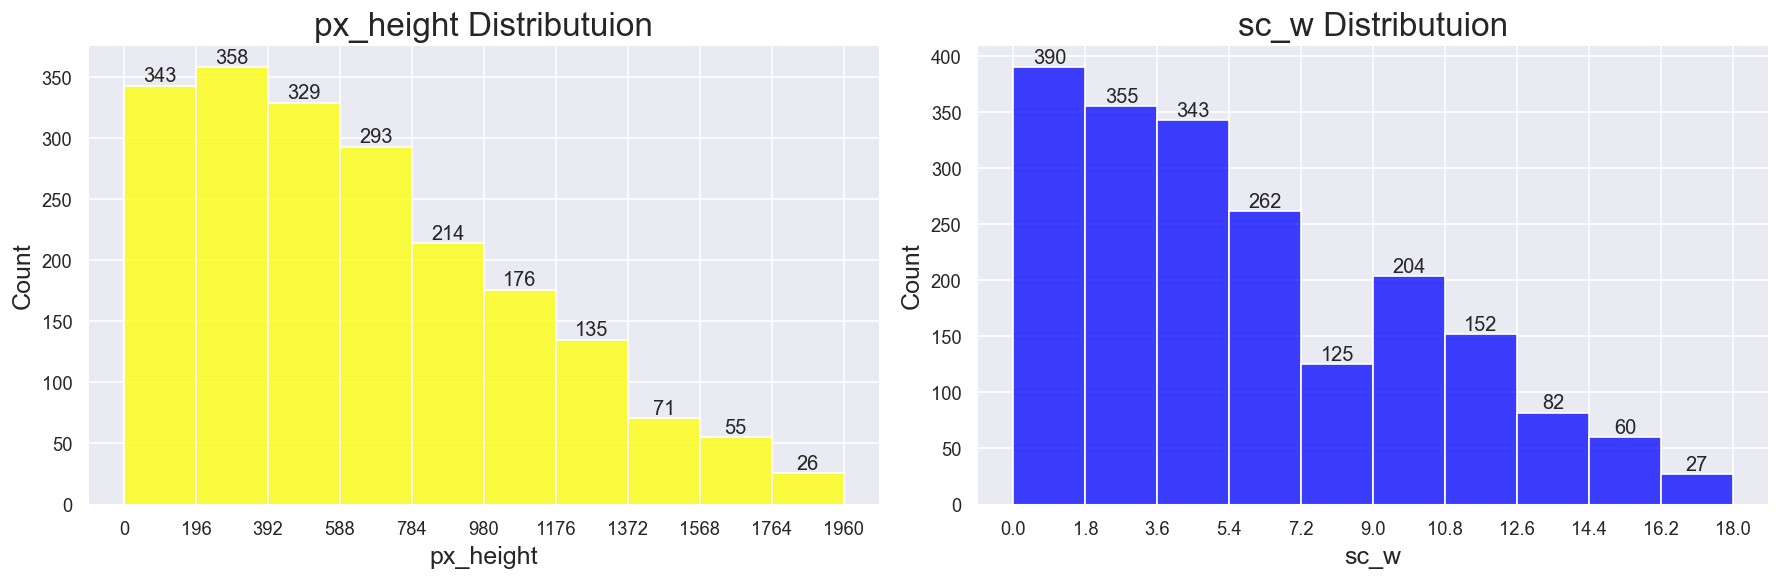

In [17]:
sns.set(rc = {'axes.labelsize' : 15})               
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)

# Plot px_height histogram:
_, bin_edges = np.histogram(df['px_height'], range=(np.floor(df['px_height'].min()), np.ceil(df['px_height'].max())))                                     
graph1 = sns.histplot(x='px_height', data=df, bins=bin_edges, color='yellow', ax=ax[0])
ax[0].set_xticks(np.round(bin_edges,1))
ax[0].set_title('px_height Distributuion', fontsize=20) 
for cont in graph1.containers:
        graph1.bar_label(cont)

# Plot sc_w histogram:
_, bin_edges = np.histogram(df['sc_w'], range=(np.floor(df['sc_w'].min()), np.ceil(df['sc_w'].max())))
graph2 = sns.histplot(x='sc_w', data=df, bins=bin_edges, color='blue', ax=ax[1])
ax[1].set_xticks(np.round(bin_edges,1))
ax[1].set_title('sc_w Distributuion', fontsize=20)      
for cont in graph2.containers:
        graph2.bar_label(cont)
        
plt.tight_layout()
plt.show()


In [18]:
# Detect Noise values in sc_w 
sc_w_NoiseIndex = df[df['sc_w'] < 2].index

# Detect Noise values in px_height
px_height_NoiseIndex = df[df['px_height'] < 5].index


In [19]:
print('The number of detected noise values for sc_w: ', len(sc_w_NoiseIndex))
print('The number of detected noise values for px_height: ', len(px_height_NoiseIndex))


The number of detected noise values for sc_w:  390
The number of detected noise values for px_height:  9


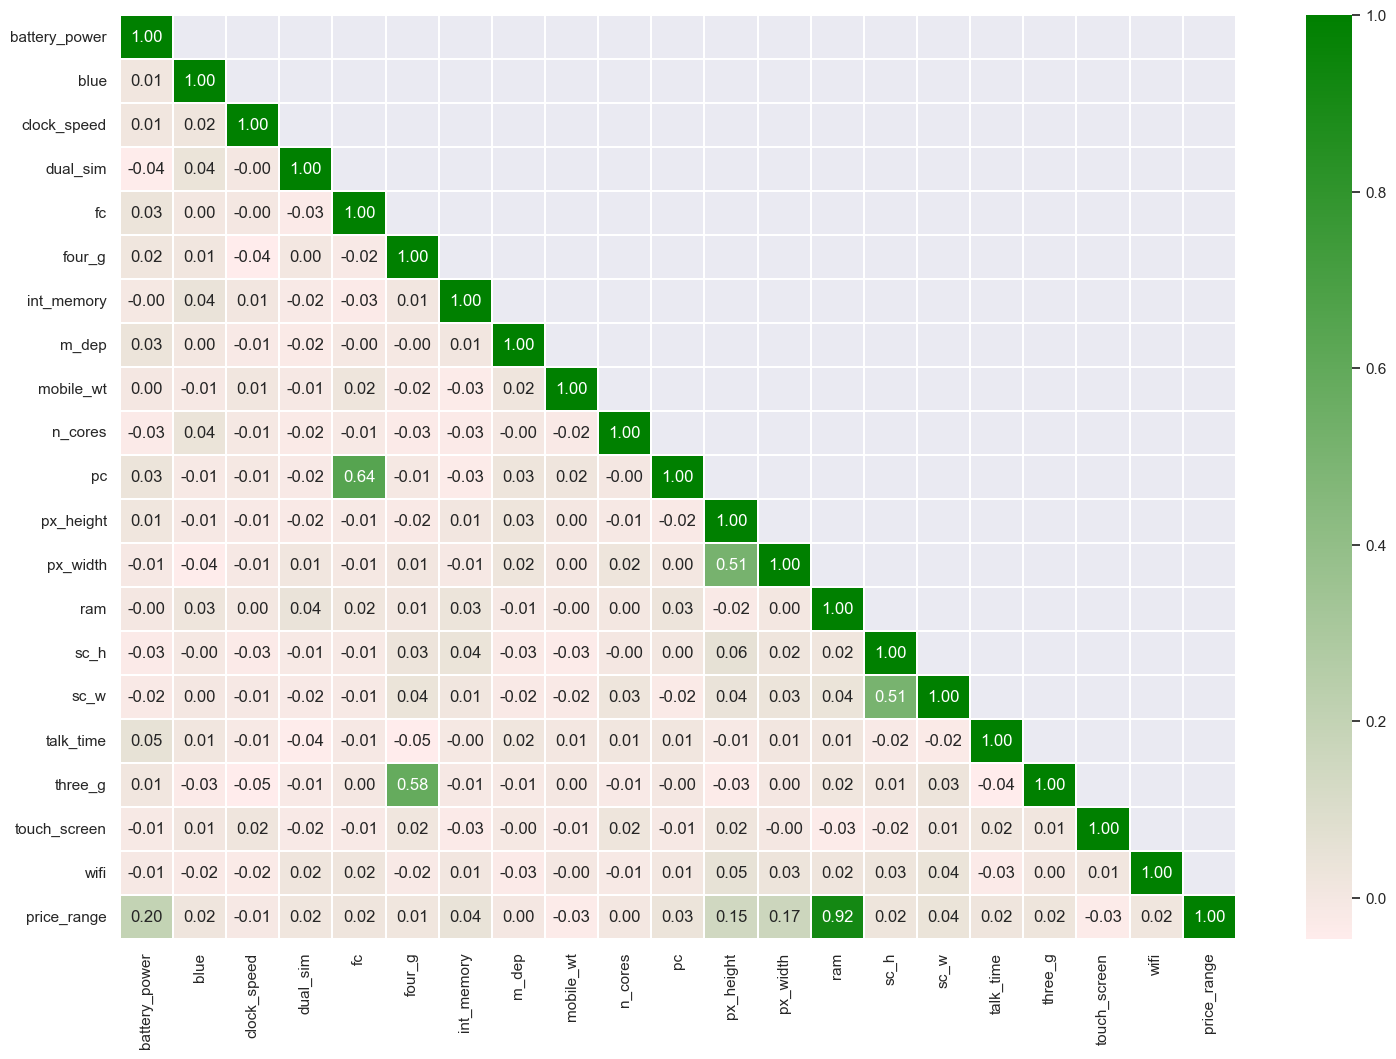

In [20]:
# Define a colormap
orangered_cmap = LinearSegmentedColormap.from_list('orangered', ['#FFECEC','green'])

# Calculation of the Spearman correlation
target = 'price_range'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr()

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(18,12))
sns.heatmap(corr, mask=mask, annot=True, cmap=orangered_cmap, fmt='.2f', linewidths=0.2)
plt.show()


In [21]:
def drop_column_importance(model, X_train, y_train, random_state=0):
    
    
    # list containing feature importances
    importances = []
    # Clone the model
    model_clone = clone(model)
    # Set random_state for comparability
    model_clone.random_state = random_state
    # Train the model
    model_clone.fit(X_train, y_train)
    # Create the cross-validation object using StratifiedKFold 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Score the benchmark model using cross-validation
    benchmark_score = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring='accuracy').mean()

    for col in X_train.columns:
        # Clone the model
        model_clone = clone(model)
        # Set random_state for comparability
        model_clone.random_state = random_state
        # Traint the model on the the dataset with a single feature removed
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        # Score the droped-column model
        drop_column_score = cross_val_score(model_clone, X_train.drop(col,axis=1), y_train, cv=cv, scoring='accuracy').mean()
        # Store feature importance which is defined as the difference between the benchmark and the new model score
        importances.append(benchmark_score - drop_column_score)
        
    # Return the features along with their importances in the form of a dataframe
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending = False).reset_index(drop = True)
           
    return importances_df                  

In [22]:
def drop_column_importance_plot(model, X_train, y_train):
    
    
   
    df_drop_column = drop_column_importance(model, X_train, y_train, random_state=0)
   
    df_drop_column.columns = ['Feature', 'Feature Importance']
    
    # Plot barchart
    plt.figure(figsize=(12,10))
    sns.barplot(data=df_drop_column, x='Feature Importance', y='Feature', orient='h', color='blue')
    plt.title('Drop Column Feature Importance', fontsize=20)
    plt.show()


In [23]:
# Define the target name in a variable for simplicity
Target = 'price_range'

# Define a list containing names of the categorical features in the dataset 
Cat_Features = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'n_cores']


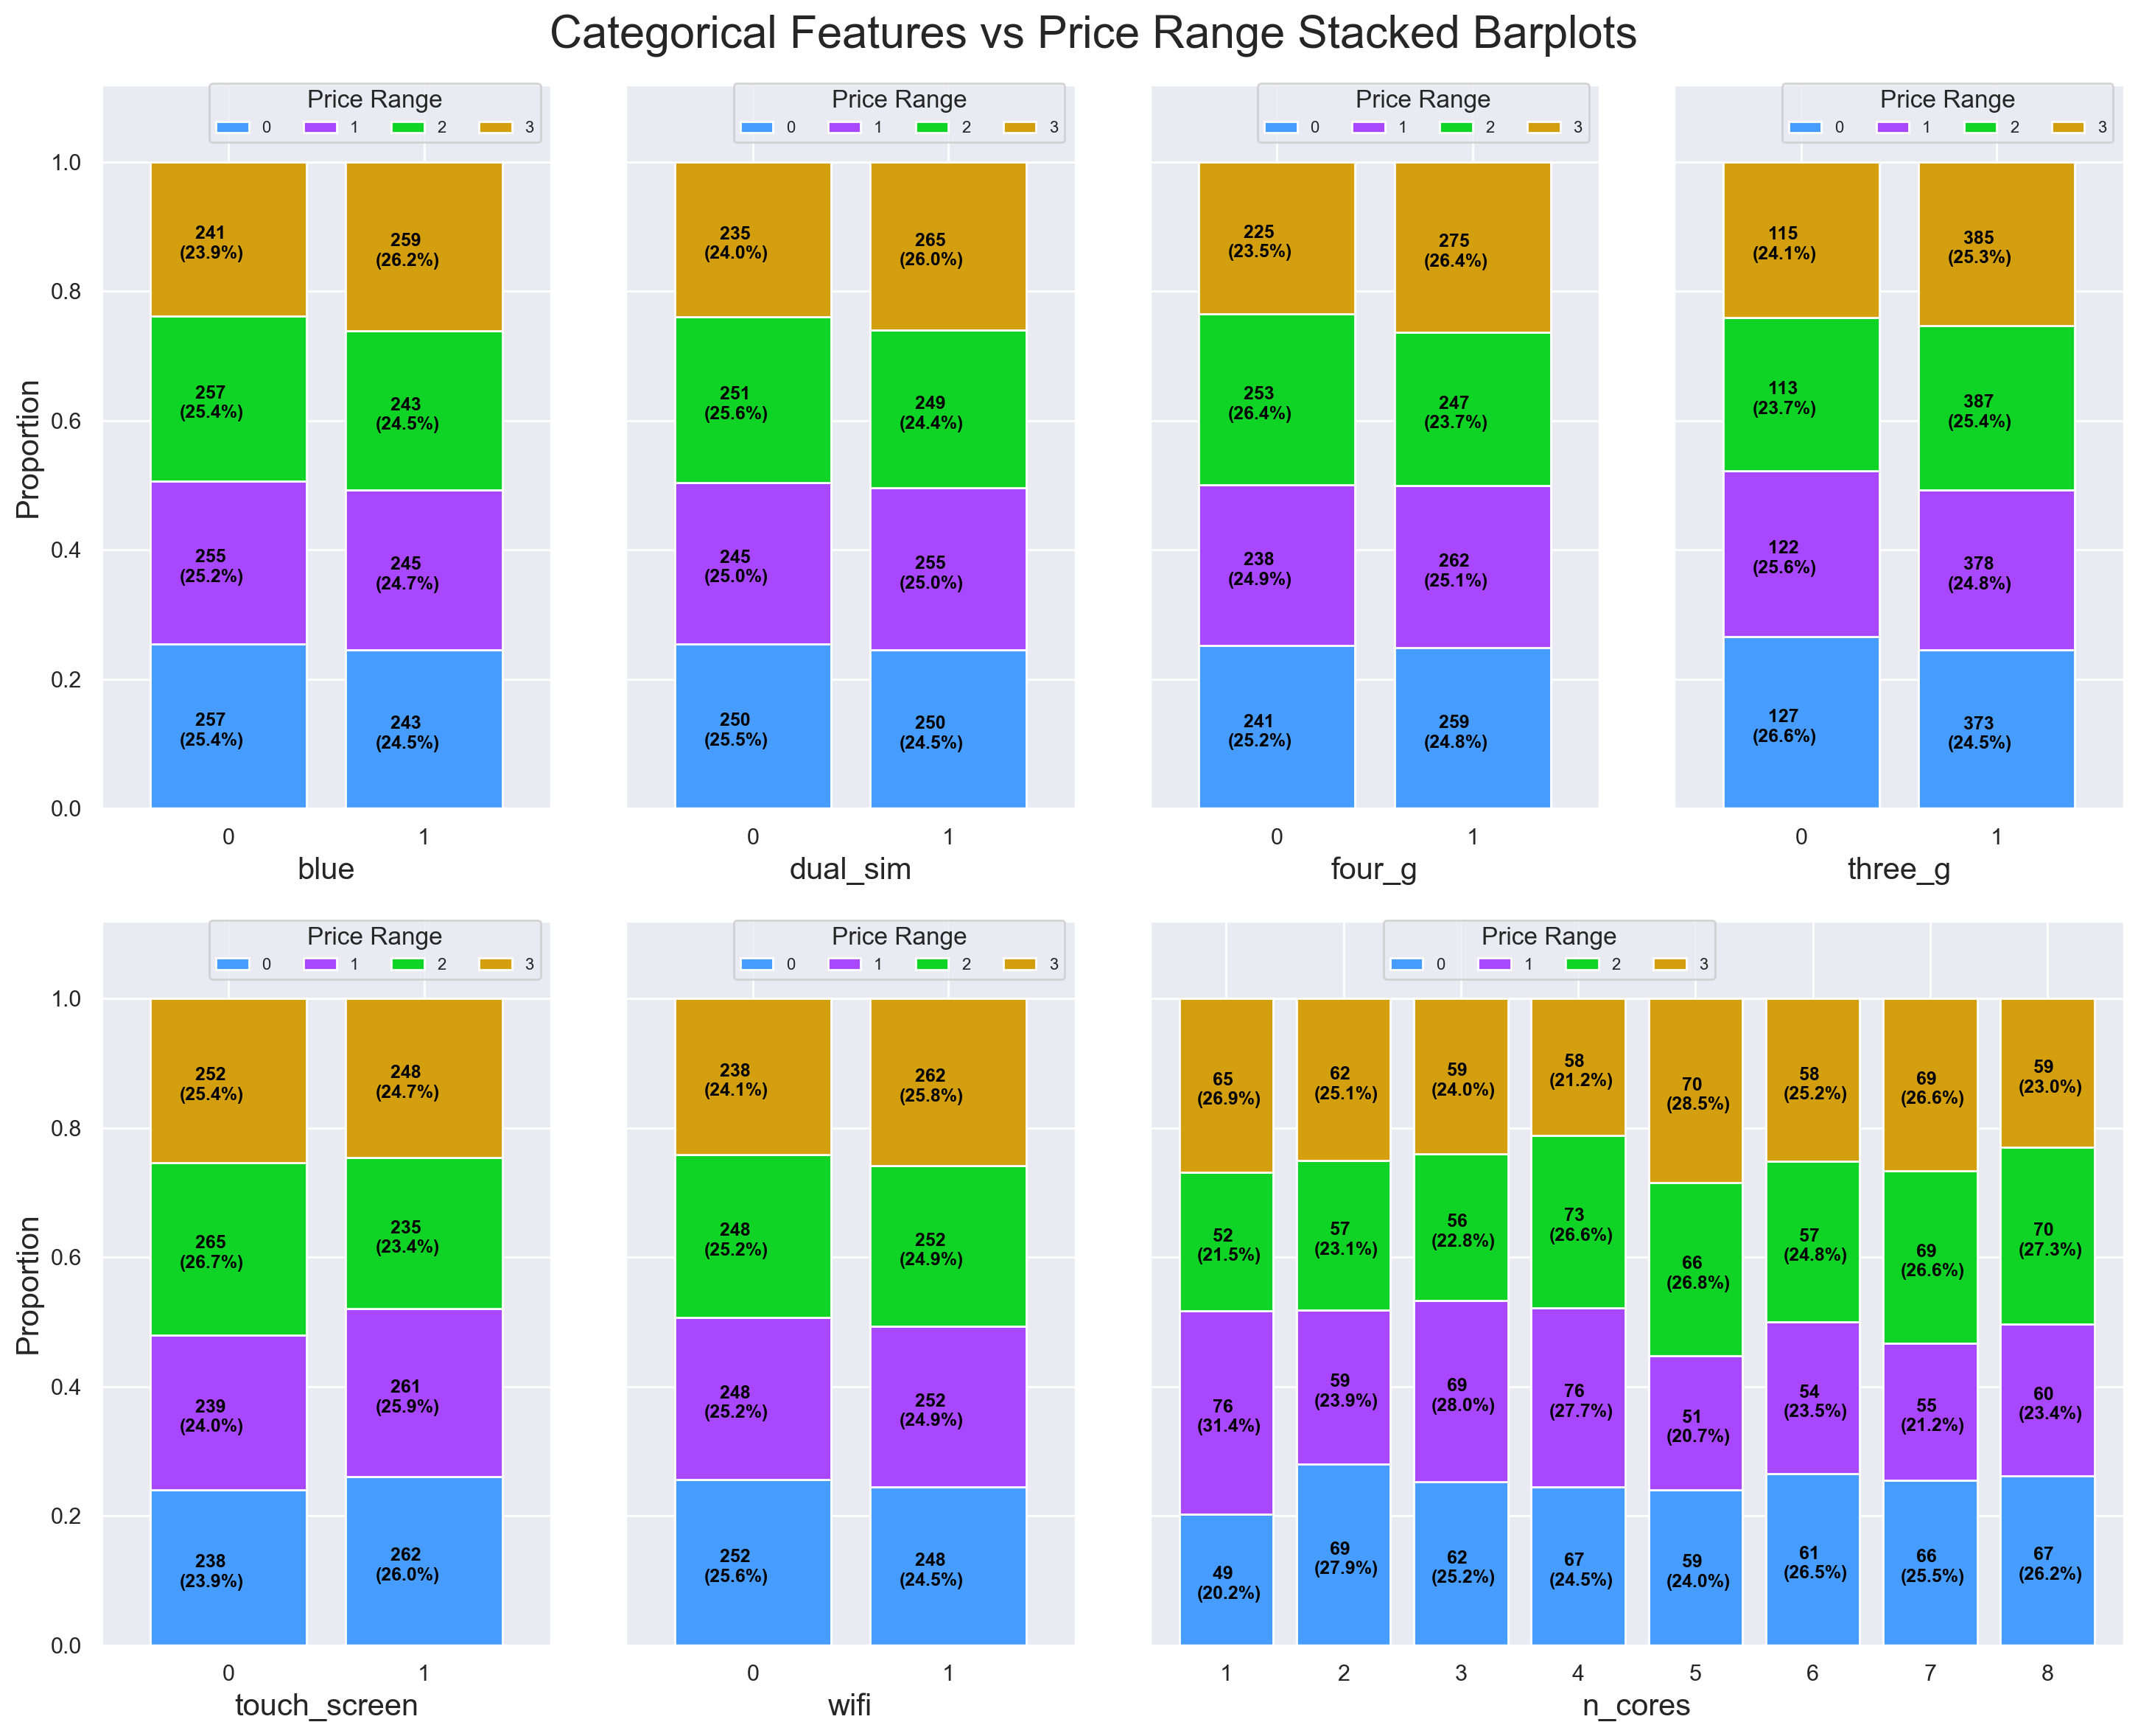

In [27]:
# Create a 2x4 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,12), dpi=200)

# Span subplot over two columns
ax[1,2] = plt.subplot2grid((2,4), (1,2), colspan=2)

for i,col in enumerate(Cat_Features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#479dff', '#a947ff', '#0fd426','#d49f0f'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.25, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'   {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='Price Range', loc=(0.24,0.92), fontsize=8, ncol=4)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    # Increase xlabel & ylabel font sizes
    ax[x,y].set_ylabel('Proportion', fontsize=15)
    ax[x,y].set_xlabel(col, fontsize=15)        

plt.suptitle('Categorical Features vs Price Range Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

In [28]:
# Define a list containing names of the numerical features in the dataset 
Num_Features = df_numerical.columns


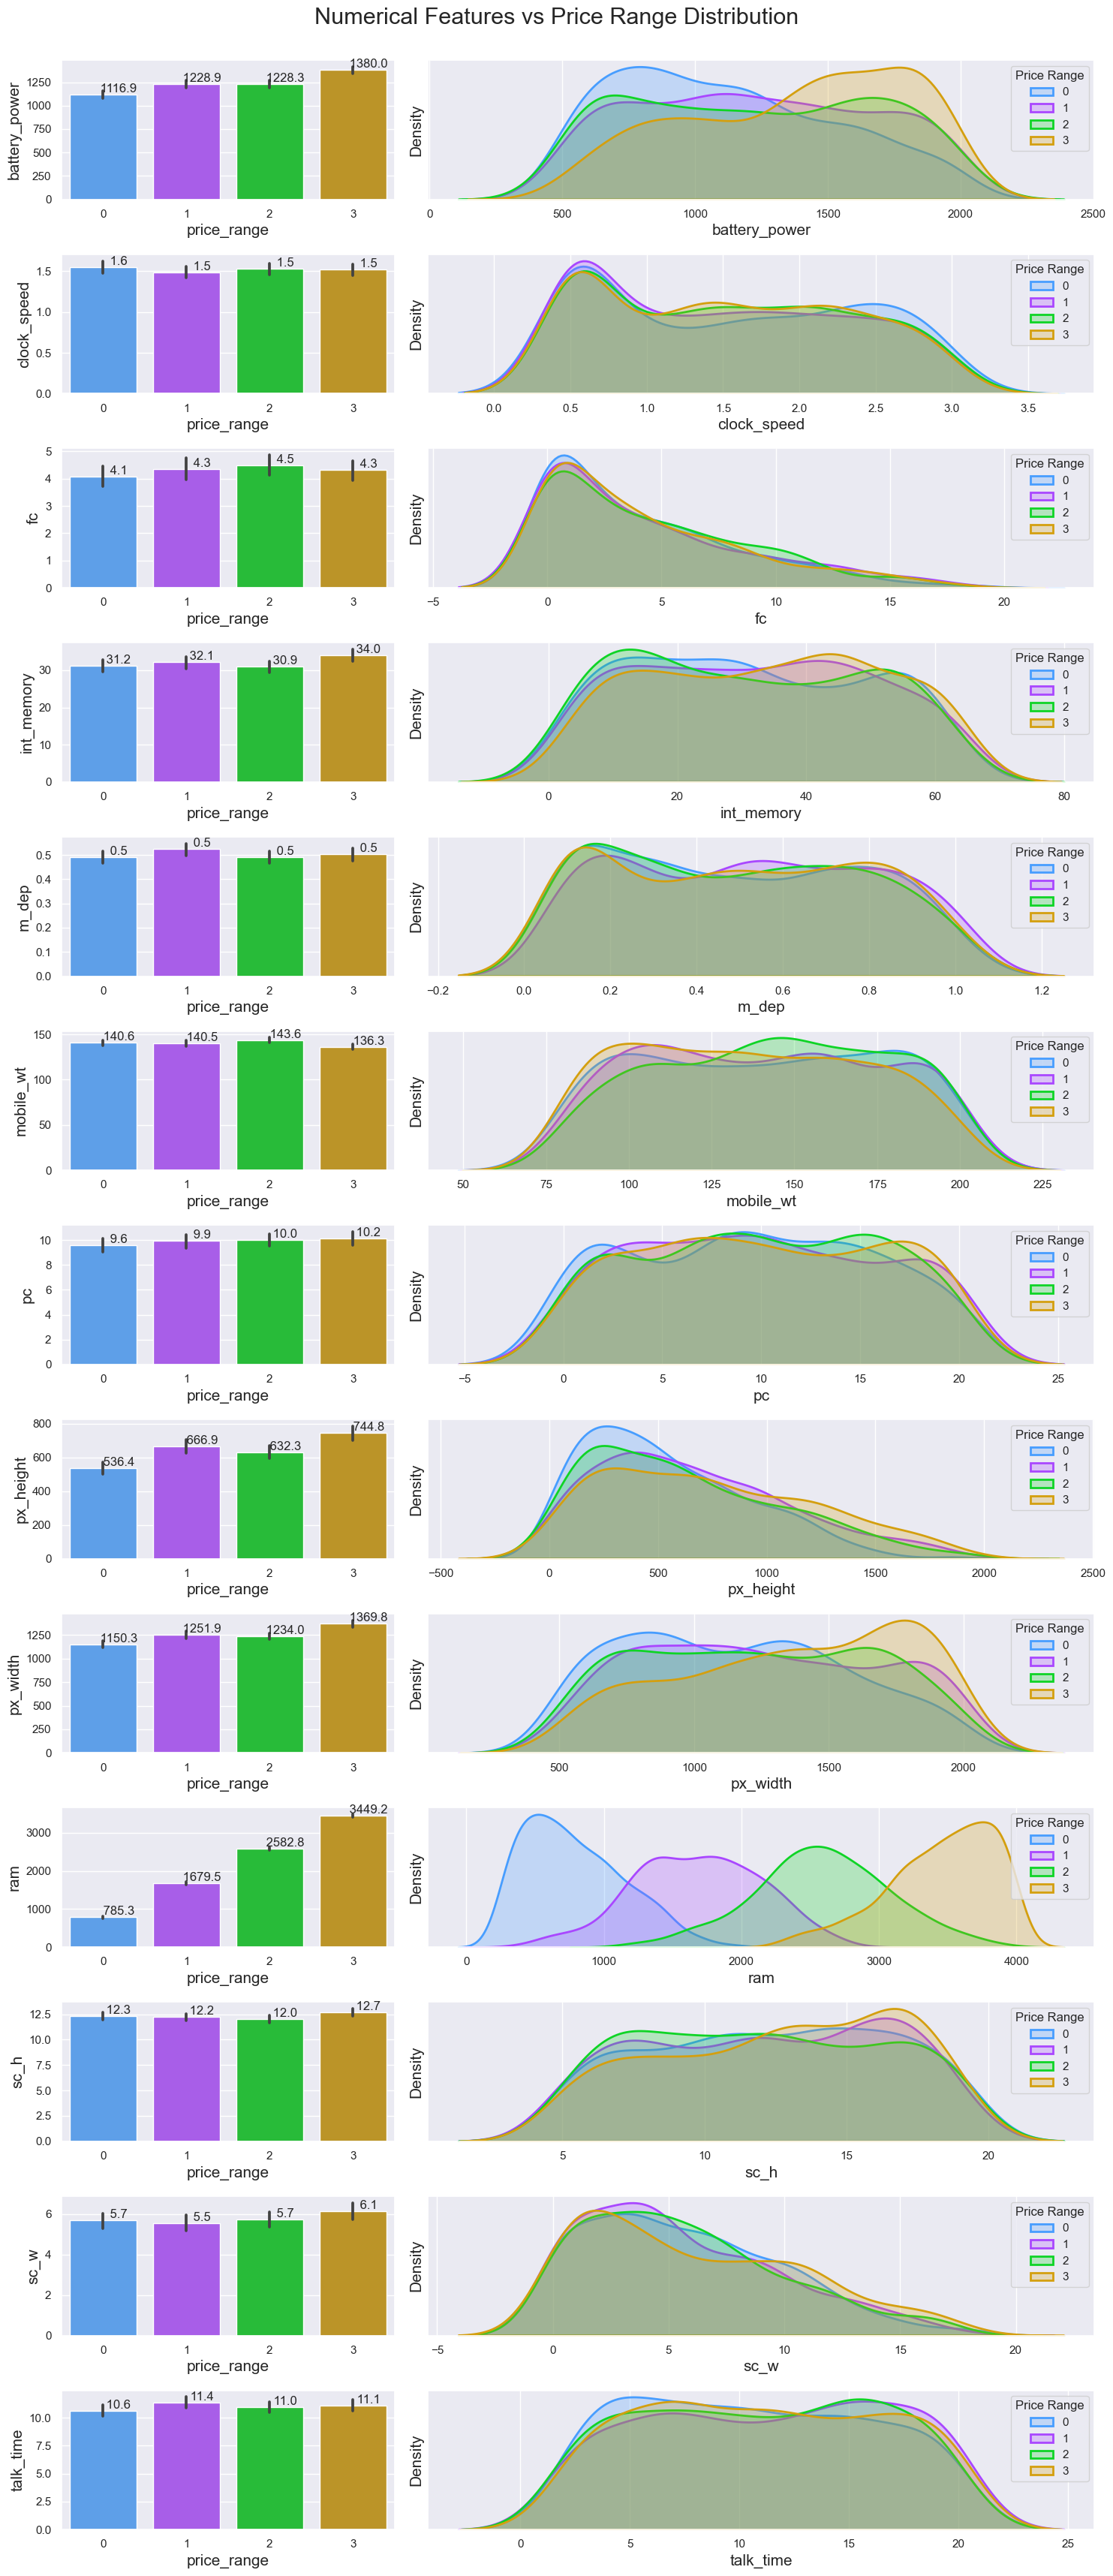

In [29]:
# Define Seaborn palette
sns.set_palette(['#479dff', '#a947ff', '#0fd426','#d49f0f'])

# Create a 13x2 grid of subplots
fig, ax = plt.subplots(13, 2, figsize=(15,35), gridspec_kw={'width_ratios': [1, 2]})

for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    sns.kdeplot(data=df[df[Target]==2], x=col, fill=True, linewidth=2, ax=ax[i,1], label='2')
    sns.kdeplot(data=df[df[Target]==3], x=col, fill=True, linewidth=2, ax=ax[i,1], label='3')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Price Range', loc='upper right')
    # Add bar sizes to our plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.1f')
        
# Increase font size of x and y labels
for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i,j].set_xlabel(ax[i,j].get_xlabel(), fontsize=15)
        ax[i,j].set_ylabel(ax[i,j].get_ylabel(), fontsize=15)

plt.suptitle('Numerical Features vs Price Range Distribution', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()


In [30]:
X = df.drop('price_range', axis=1)
y = df['price_range'] 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [32]:
# Scale the training and test data using Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert training and test sets from numpy array to pandas dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [33]:
def tune_hyperparameters(clf, param_grid, X_train, y_train):
    
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

In [34]:
# Define the hyperparameter grid to search
param_grid = [{'kernel': ['poly'], 
               'degree': [2, 3, 4, 5], 
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
               'C': [0.01, 0.1, 1, 10, 100, 1000]},
                  
              {'kernel': ['rbf','sigmoid'],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
               'C': [0.01, 0.1, 1, 10, 100, 1000]},
                  
              {'kernel': ['linear'],
               'C': [0.01, 0.1, 1, 10, 100, 1000]}
             ]


In [35]:
param_grid = {'kernel': ['linear'],
               'C': [ 0.1, 1, 10, 50, 100]
             }


In [36]:
# Create a SVC object
svm = SVC(probability=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
svm_optimized = tune_hyperparameters(svm, param_grid, X_train, y_train)


Best hyperparameters:
 {'C': 50, 'kernel': 'linear'}


In [37]:
def metrics_calculator(clf, X_test, y_test, model_name):
    
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result


In [41]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports and confusion matrix
    '''
    # Set font scale
    sns.set(font_scale=1.5)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')
    
    # Create figure and subplots 
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=90, figsize=(12, 5))
    
    
    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax1.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 4.2)
    table.set_fontsize(12)
    ax1.axis('tight')
    # Hide the axes
    ax1.axis('off')
    # set the title
    ax1.set_title('{} Performance Summary on Test Data'.format(model_name), fontsize=18)
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('orangered')
              
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=orangered_cmap, ax=ax2)
    ax2.set_title('Confusion Matrix for Test Data')                                     
    ax2.grid(False)
            
    plt.tight_layout()
    plt.show() 



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.98      0.97      0.98       400
           2       0.98      0.98      0.98       400
           3       0.99      0.99      0.99       400

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       0.99      0.97      0.98       100
           2       0.97      0.98      0.98       100
           3       0.99      0.98      0.98       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98 

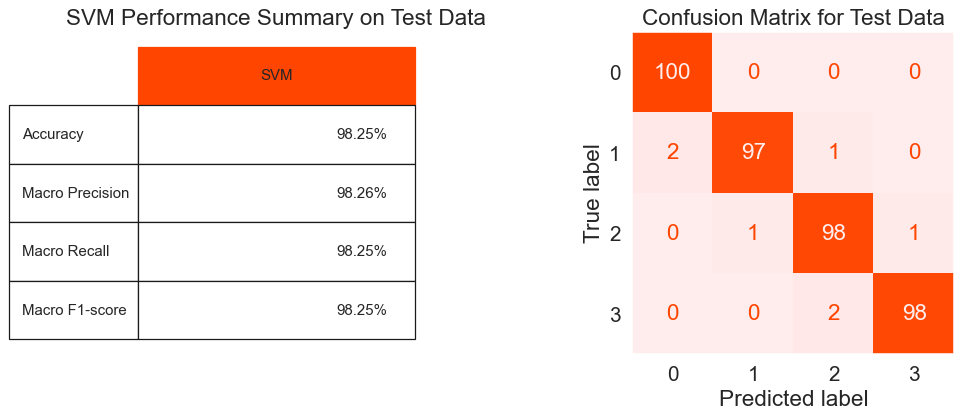

In [32]:
model_evaluation(svm_optimized, X_train, X_test, y_train, y_test, 'SVM')

In [42]:
# Save the final performance of SVM classifier
svm_result = metrics_calculator(svm_optimized, X_test, y_test, 'SVM')

In [43]:
# Make a copy of dataset
df_denoised = df.copy()

# Replace the noise values with NaN
df_denoised.loc[sc_w_NoiseIndex,'sc_w'] = np.nan
df_denoised.loc[px_height_NoiseIndex,'px_height'] = np.nan

# Create a KNN imputer object with k=2
imputer = KNNImputer(n_neighbors=2)

# Impute the noise values
imputed_data = imputer.fit_transform(df_denoised)

# Convert array to dataframe
df_denoised = pd.DataFrame(imputed_data, columns=df_denoised.columns)

# Define the features (X) and the output labels (y)
X_denoised = df_denoised.drop('price_range', axis=1)
df_denoised['price_range'] = df_denoised['price_range'].astype(int)
y = df_denoised['price_range'] 

In [44]:
# Define the hyperparameter grid
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 15),
              'min_samples_split': np.arange(2, 10),
              'min_samples_leaf': np.arange(1, 10),
              'max_features': [None, 'sqrt', 'log2']} 


In [45]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X_denoised, y, test_size=0.2, random_state=0, stratify=y)

# Create a  Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=0)

# Find the best classifier with the optimal hyperparameters
dt_optimized = tune_hyperparameters(dt, param_grid, X_train, y_train)


Best hyperparameters:
 {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8}


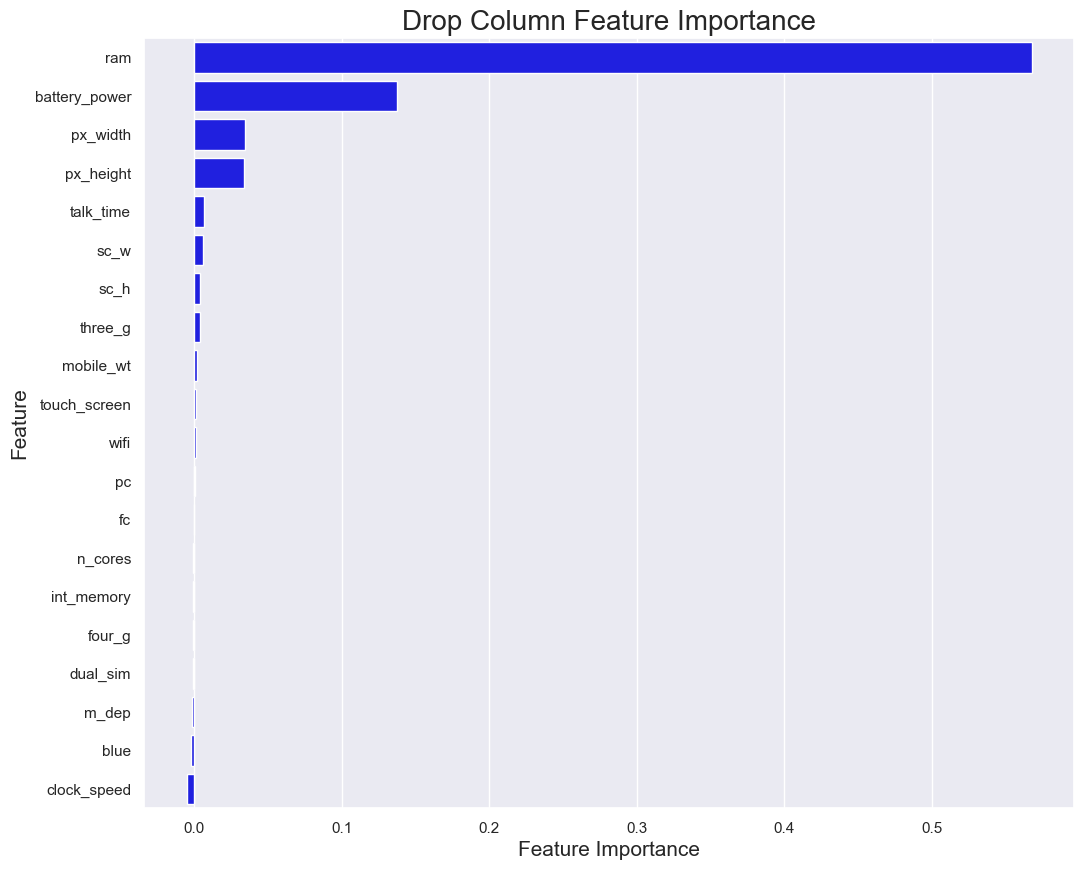

In [46]:
drop_column_importance_plot(dt_optimized, X_train, y_train)

In [47]:
# Find Important features with positive feature_importance value
feature_importances = drop_column_importance(dt_optimized, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature']  # Threshold value of 0.01

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [48]:
pd.DataFrame(selected_features)


,feature
0,ram
1,battery_power
2,px_width
3,px_height


In [49]:
# Create a  Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=0)

# Find the best classifier with the optimal hyperparameters
dt_optimized = tune_hyperparameters(dt, param_grid, X_train, y_train)

Best hyperparameters:
 {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 7}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.96      0.94      0.95       400
           2       0.91      0.97      0.94       400
           3       0.98      0.94      0.96       400

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       100
           1       0.85      0.87      0.86       100
           2       0.82      0.85      0.83       100
           3       0.92      0.86      0.89       100

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88 

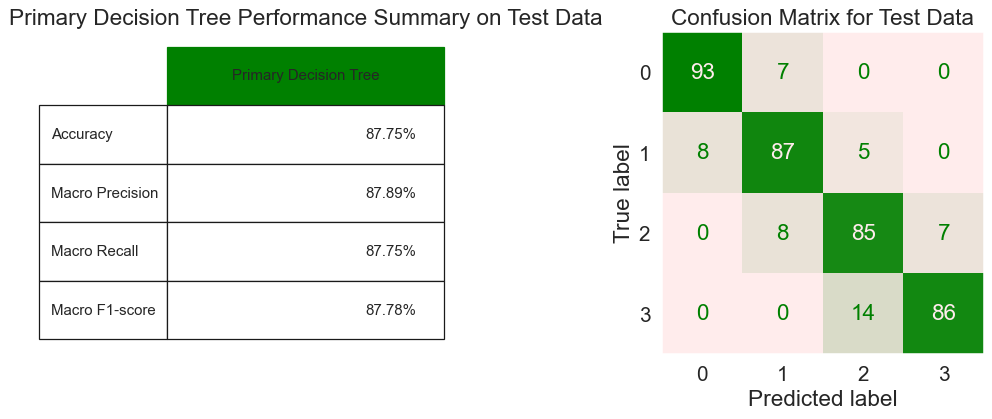

In [50]:
model_evaluation(dt_optimized, X_train, X_test, y_train, y_test, 'Primary Decision Tree')


In [51]:
# Build decision tree classifier considering the obtained optimal values for hyperparameters
dt_final = DecisionTreeClassifier(criterion='gini', 
                                  max_depth=8, 
                                  max_features=None, 
                                  min_samples_leaf=3, 
                                  min_samples_split=7,
                                  random_state=0)

# Train the final decision tree classifier
dt_final.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=7,
                       random_state=0)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       400
           1       0.95      0.94      0.94       400
           2       0.93      0.94      0.94       400
           3       0.97      0.95      0.96       400

    accuracy                           0.95      1600
   macro avg       0.96      0.95      0.96      1600
weighted avg       0.96      0.95      0.96      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       100
           1       0.86      0.88      0.87       100
           2       0.83      0.86      0.85       100
           3       0.94      0.87      0.90       100

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89 

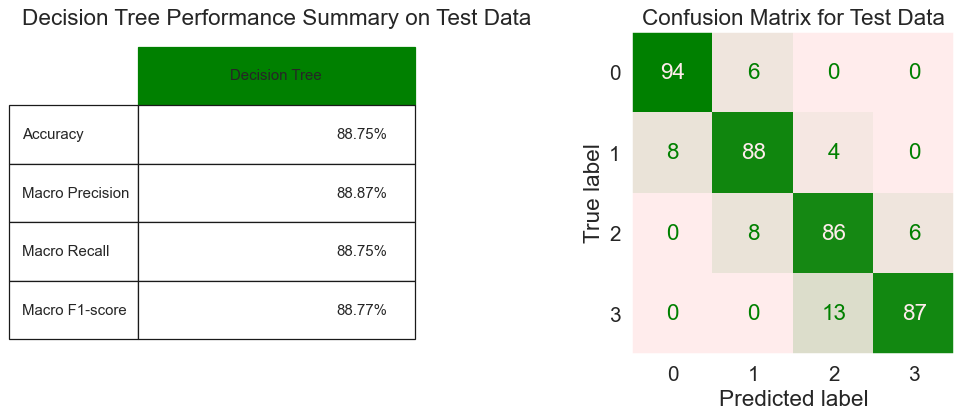

In [52]:
model_evaluation(dt_final, X_train, X_test, y_train, y_test, 'Decision Tree')


In [53]:
# Save the final performance of Decision Tree classifier
dt_result = metrics_calculator(dt_final, X_test, y_test, 'Decision Tree')



In [54]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [70, 100, 120, 150], 
    'max_depth': np.arange(10, 18),
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}


In [55]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X_denoised, y, test_size=0.2, random_state=0, stratify=y)

# Create a random forest classifier object
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
rf_optimised = tune_hyperparameters(rf, param_grid, X_train, y_train)


Best hyperparameters:
 {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}


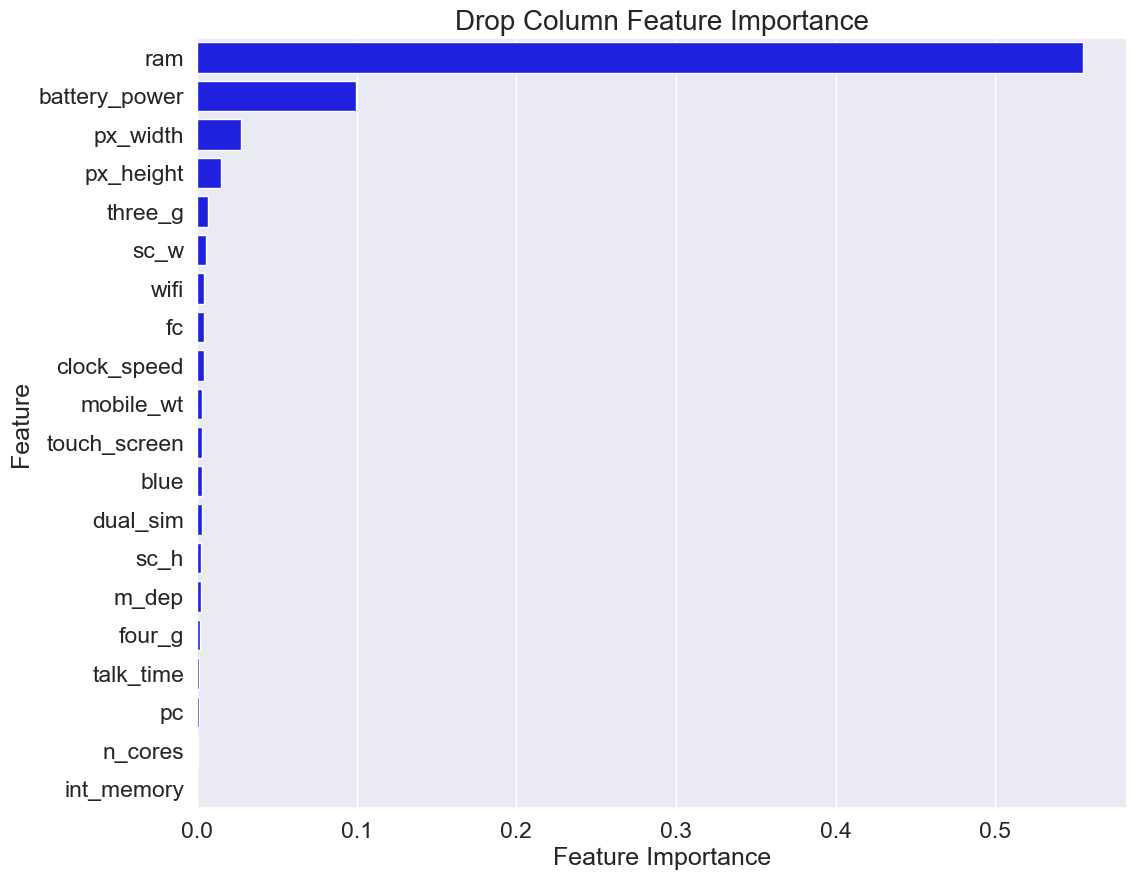

In [56]:
drop_column_importance_plot(rf_optimised, X_train, y_train)


In [57]:
feature_importances = drop_column_importance(rf_optimised, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature']  # Threshold value of 0.01

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]


In [58]:
pd.DataFrame(selected_features)


,feature
0,ram
1,battery_power
2,px_width
3,px_height


In [59]:
# Create a random forest classifier object
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
rf_optimised = tune_hyperparameters(rf, param_grid, X_train, y_train)


Best hyperparameters:
 {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       100
           1       0.91      0.91      0.91       100
           2       0.84      0.87      0.85       100
           3       0.93      0.89      0.91       100

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91 

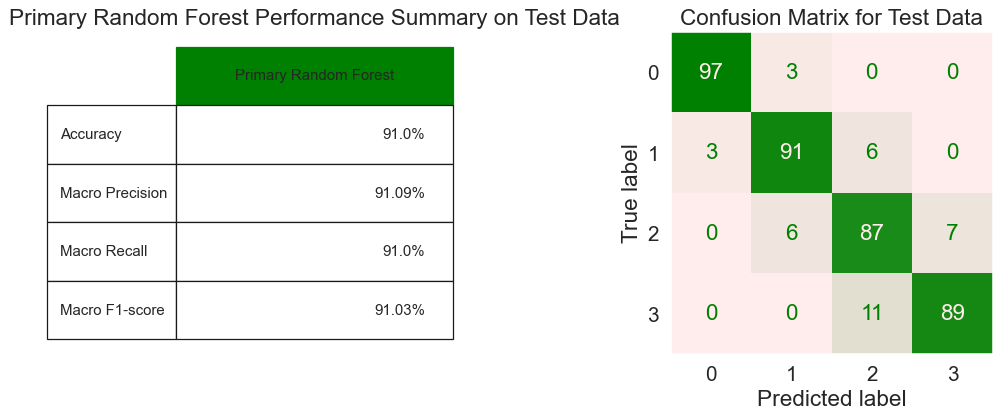

In [60]:
model_evaluation(rf_optimised, X_train, X_test, y_train, y_test, 'Primary Random Forest')


In [61]:
# Build decision tree classifier considering the obtained optimal values for hyperparameters
rf_final = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0,
                                  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=90)

# Train the final decision tree classifier
rf_final.fit(X_train, y_train)


RandomForestClassifier(max_depth=13, max_features=None, min_samples_leaf=4,
                       n_estimators=90, random_state=0)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.96      0.97      0.97       400
           2       0.97      0.97      0.97       400
           3       0.99      0.97      0.98       400

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       100
           1       0.91      0.93      0.92       100
           2       0.85      0.88      0.87       100
           3       0.93      0.89      0.91       100

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92 

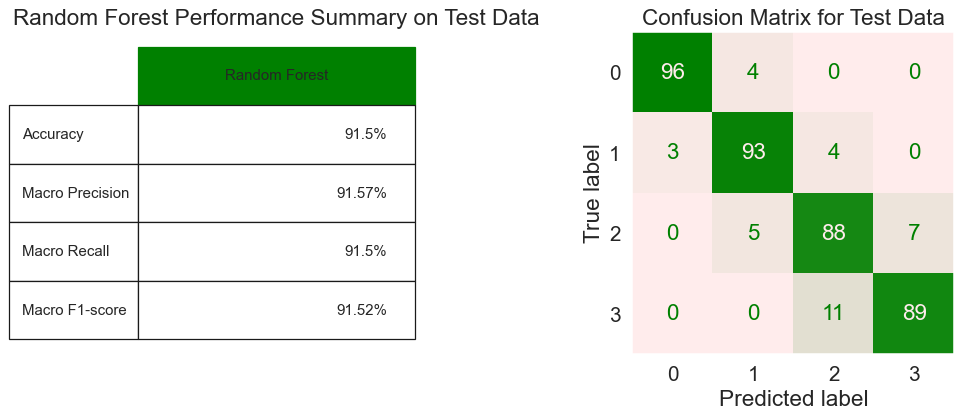

In [62]:
model_evaluation(rf_final, X_train, X_test, y_train, y_test, 'Random Forest')


In [63]:
# Save the final performance of Random Forest classifier
rf_result = metrics_calculator(rf_final, X_test, y_test, 'Random Forest')



In [65]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([svm_result, dt_result, rf_result], axis=1).T

# Sort the dataframe in descending order based on accuracy
results.sort_values(by='Accuracy', ascending=False, inplace=True)

# Color the accuracy column
results.style.applymap(lambda x: 'background-color: red', subset='Accuracy')


,Accuracy,Macro Precision,Macro Recall,Macro F1-score
SVM,98.25%,98.26%,98.25%,98.25%
Random Forest,91.5%,91.57%,91.5%,91.52%
Decision Tree,88.75%,88.87%,88.75%,88.77%


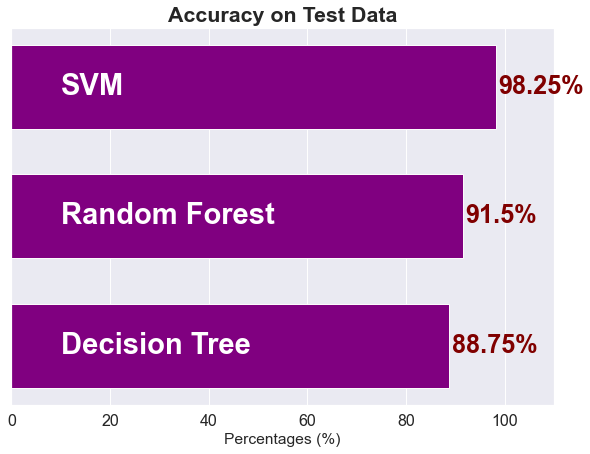

In [70]:
# Prepare values
results.sort_values(by='Accuracy', ascending=True, inplace=True)
accuracies = results['Accuracy'].str.strip('%').astype(float)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 7), dpi=70)
ax.barh(results.index, accuracies, color='purple', height=0.65)

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(accuracies, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='maroon', fontsize=26)
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=30)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0,110])

# Add title and xlabel
plt.title("Accuracy on Test Data", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()


In [71]:
# Define the features (X) and the output labels (y) of the given dataset:
X = df.drop('price_range', axis=1)
y = df['price_range'] 

# Create a pipeline to scale the data and train an SVM classifier using obtained optimal hyperparameters
svm_pipeline = Pipeline([
                         ('scaler', StandardScaler()), 
                         ('svm', SVC(probability=True, C=50, kernel='linear', random_state=0)) 
                        ])

# Train the SVM classifier on the whole dataset
svm_pipeline.fit(X, y)

# Read samples
df_samples = pd.read_csv('mobile_price_range_data.csv')
# Remove id column
df_samples.drop("price_range",axis=1, inplace=True)


# Predict samples class
df_samples['price_range_pred'] = svm_pipeline.predict(df_samples)
df_samples['price_range_pred']


0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range_pred, Length: 2000, dtype: int64